**Labels pool preparation**

We use Wikipedia Portal titles to serve as a Label Pool
The Label Pool is created via traversing a raw Wikipedia dump, and identifying Portals, i.e. articlea having title that starts from "Portal:"

In [ ]:
# download raw Wikipedia dump
!wget --continue https://dumps.wikimedia.org/enwiki/20180301/enwiki-20180301-pages-articles.xml.bz2

In [ ]:
# create labels pool
# from Wikipedia Portal titles
import bz2
import gensim

# wikipedia dump
f = bz2.BZ2File('enwiki-20180301-pages-articles.xml.bz2')

# create iterator traversing on pages
pages = gensim.corpora.wikicorpus.extract_pages(f,('0',))

# extract page titles starting from Portal: and prune the titles
ns = 'Portal:'
labels = [title[len(ns):].split('/')[0].lower().strip('\n') for title,_ in pages if title.startswith(ns)]

# remove duplicates
labels = list(set(labels))

# save Label Pool to a file
with open('labels.txt', 'w', encoding='utf-8') as labels_file:
    for label in labels:
        labels_file.write(label + '\n')

In [ ]:
!sudo pip3 install gensim

In [ ]:
!sudo pip install seaborn

**Build special word embeddings, as unified embedding space for words AND labels from Label pool**

Labels from Label Pool converted to Phrases, i.e. joined by _ delimiter 

In [ ]:
# load preprocessed Wikipedia texts as a preparation for word embeddings
import gensim.downloader
from gensim.parsing.preprocessing import *

corpus = gensim.downloader.load("wiki-english-20171001")

In [ ]:
# Retrieve Label Pool from a file
with open('labels.txt') as labels_file:
    labels = [line.strip('\n\r') for line in labels_file]

In [ ]:
# iterator used to replace labels in articles with corresponding phrases
#
# traverse articles
#     in each article, find labels from the label pool, and replace them with label phrases
#     yield processed articles
class LabelsToPhrases(object):
    def __init__(self, corpus, labels):
        self.corpus = corpus
        self.labels = labels

    def __iter__(self):
        for article in self.corpus:

            # conctatenate all texts related to an article - article title, section titles, and section texts
            text = article['title'] + ' '.join([ ' ' + section_title + section_text for section_title, section_text in zip(article['section_titles'], article['section_texts'])])

            # preprocess text but DON'T STEM with stem_text
            # this to avoid removal of _ (phrase delimiter)
            text = ' '.join(
                preprocess_string( text, filters=[
                    lambda x: x.lower(), strip_tags, strip_punctuation,
                    strip_multiple_whitespaces, strip_numeric,
                    remove_stopwords, strip_short]))

            # find in an articel text all instances of labels from the labels pool
            # and replace these by corresponding phrases, i.e. one token with words separated by a delimiter
            for label in self.labels:
                #if label in text:
                #    print("Title: {}  Phrase: {}".format(article['title'], label))
                text = text.replace( label, '_'.join(label.split()))

            # clean up the resulting text
            yield text

Replace labels' (form a Label Pool) instances in Wikipedia corpus by their Phraises representation (joined by underscore)

Store resulting corpus in a file

In [ ]:
import bz2
phrases_file = bz2.BZ2File('phrases.txt.bz2', 'wb')

# process all articles replacing labels by label phrases
# for efficenly, search for an replace only multi_word labels
for article in LabelsToPhrases(corpus, [label for label in labels if len(label.split(' '))>1]):
    phrases_file.write(bytearray(article + '\n','utf-8'))

phrases_file.close()

In [ ]:
# callback to save w2v model on end of each training iteration
from gensim.models.callbacks import CallbackAny2Vec

class EpochSaver(CallbackAny2Vec):
    "Callback to save model after every epoch"
    def __init__(self):
        self.epoch = 1
    
    def on_epoch_end(self, model):
        output_path = 'epoch{}.model'.format(self.epoch)
        print("Save model to {}".format(output_path))
        model.save(output_path)
        self.epoch += 1

epoch_saver = EpochSaver()

**Build the special words and phrases embedding space**

In [ ]:
# build w2v model including labels
from gensim.models import Word2Vec, KeyedVectors, LdaModel
from gensim.models.word2vec import LineSentence
from multiprocessing import cpu_count

embedding = gensim.models.Word2Vec( LineSentence('phrases.txt.bz2'), min_count=1, workers=cpu_count(), callbacks=[epoch_saver])   
word_vectors = embedding.wv

# save Embedding model
word_vectors.save('embeddings')

**Try the model**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


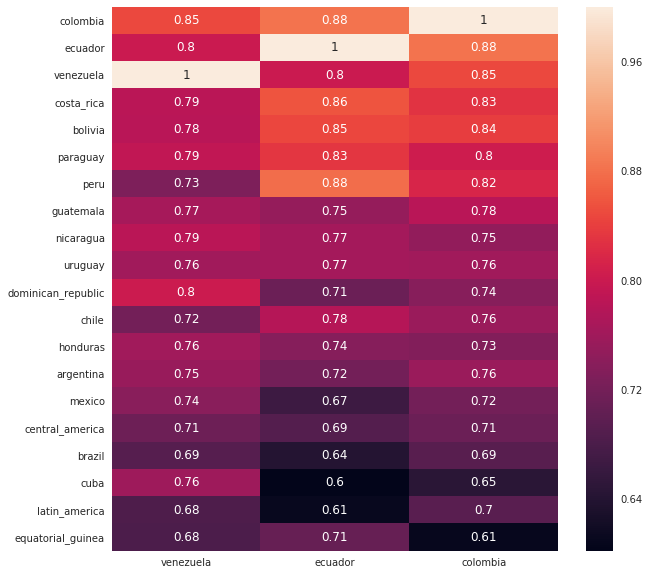

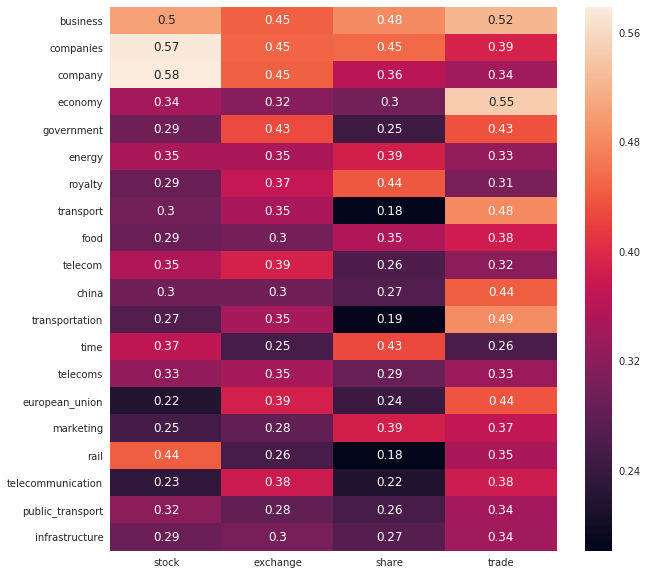

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# prune labels not appearing in word2vec vocabulary
labels =  ['_'.join(label.split()) for label in labels if '_'.join(label.split()) in word_vectors.wv.vocab]

# Topic Labeling function
def get_topic_labels(words, w2v_model, labels, labeln=20):
    
    filtered = [word for word in words if word in w2v_model.wv.vocab]
    
    # average vector for top topic words
    # TODO weighted average according to word probablities / wights
    topic_vector = sum(map(w2v_model.get_vector, filtered)) / len(filtered)

    dists = w2v_model.distances(topic_vector, other_words=labels)
    top_labels = [labels[index] for index in np.argsort(dists)[:labeln]]

    dists = np.zeros((labeln,len(filtered)))
    for ti, t in enumerate(top_labels):
        for wi, w in enumerate(filtered):
            dists[ti,wi] = word_vectors.similarity(w, t)

    dists_df = pd.DataFrame(dists, columns=filtered, index=top_labels)
    plt.figure(figsize = (10,10))
    ax = sns.heatmap(dists_df,  annot=True)

# test cases
get_topic_labels(['venezuela', 'ecuador', 'colombia'], word_vectors, labels, 20)
get_topic_labels(['stock', 'exchange','share','trade'], word_vectors, labels, 20)

#best_label = top_labels[np.argmin( np.std(dists, axis=1) )]
#print (best_label)

**Test the model on 20-newsgroups corpus**

First, build LDA model with 20 topics out of 20-newsgroups corpus

Then, for each topic find 20 best labels

In [147]:
class NewsgroupsTopicsTerms(object):
    def __init__(self):
        # retrive and cleanup 20-newsgroups corpus
        news_corpus = gensim.downloader.load('20-newsgroups')
        news_corpus = [preprocess_string( item['data'], filters=[lambda x: x.lower(), strip_tags, strip_punctuation,
                                                                 strip_multiple_whitespaces, strip_numeric,
                                                                 remove_stopwords, strip_short])
                       for item in news_corpus]
        
        self.dictionary = corpora.Dictionary(news_corpus)
        
        # train LDA model
        self.num_topics = 20
        self.lda = LdaModel([dictionary.doc2bow(text) for text in news_corpus], id2word=dictionary, num_topics=self.num_topics)
        
    def __iter__(self):
        for i in range(self.num_topics):
            yield [self.dictionary[t[0]] for t in self.lda.get_topic_terms(i)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


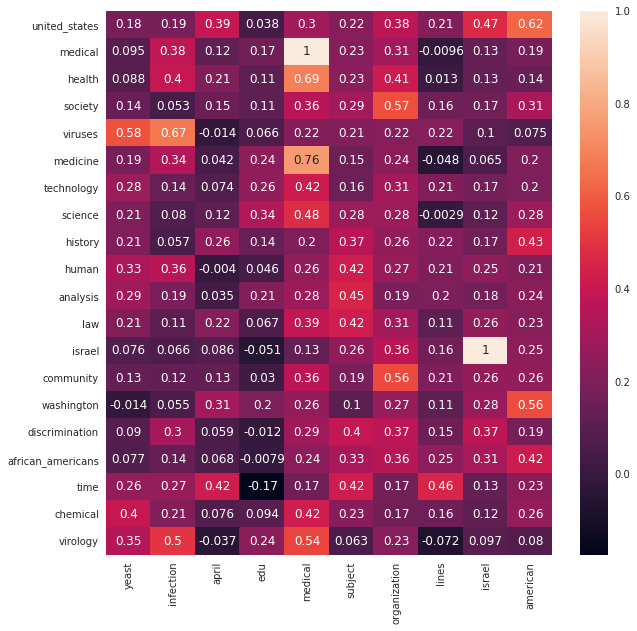

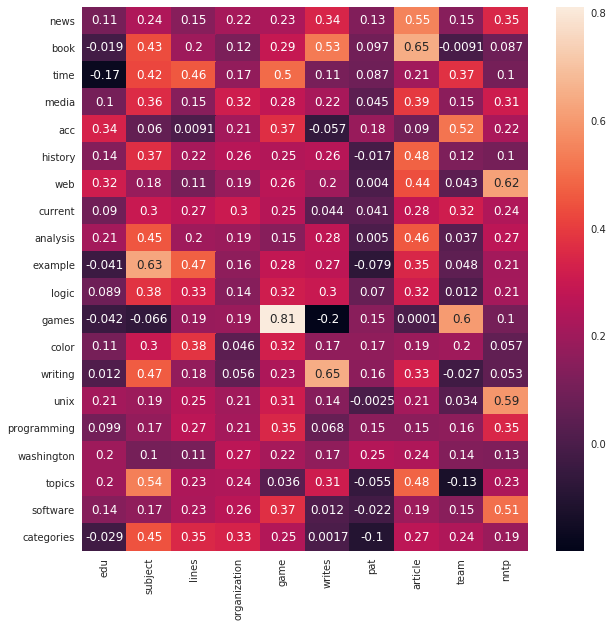

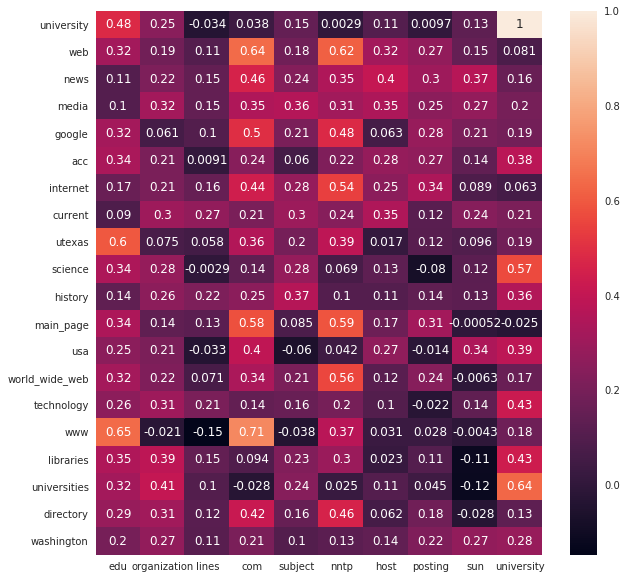

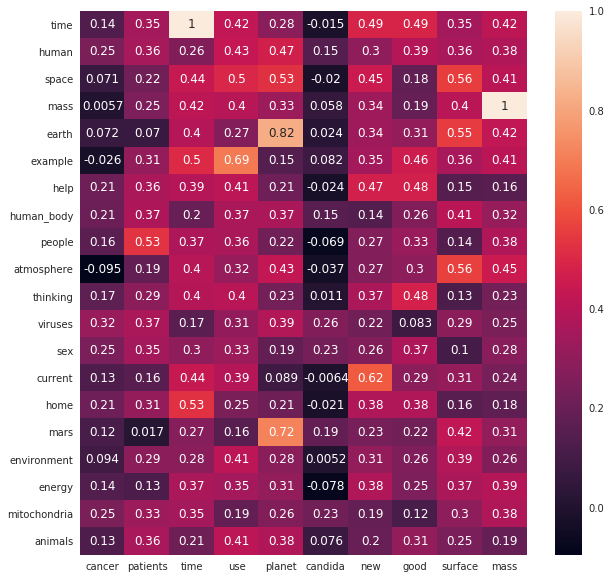

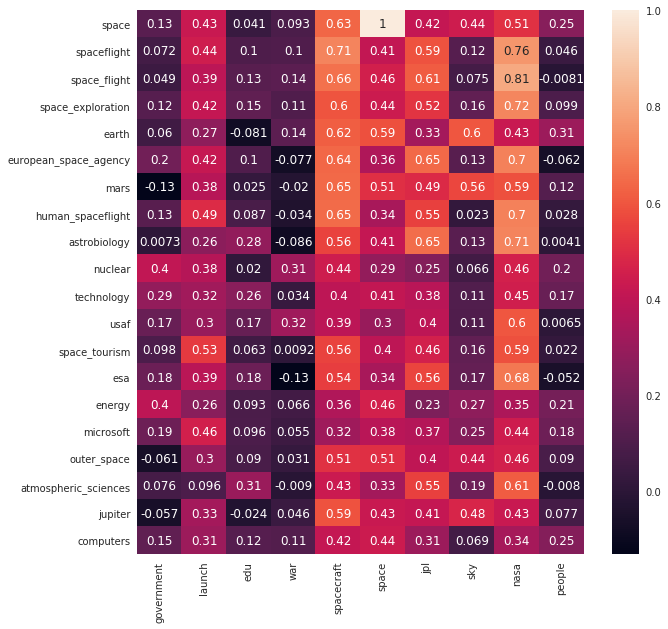

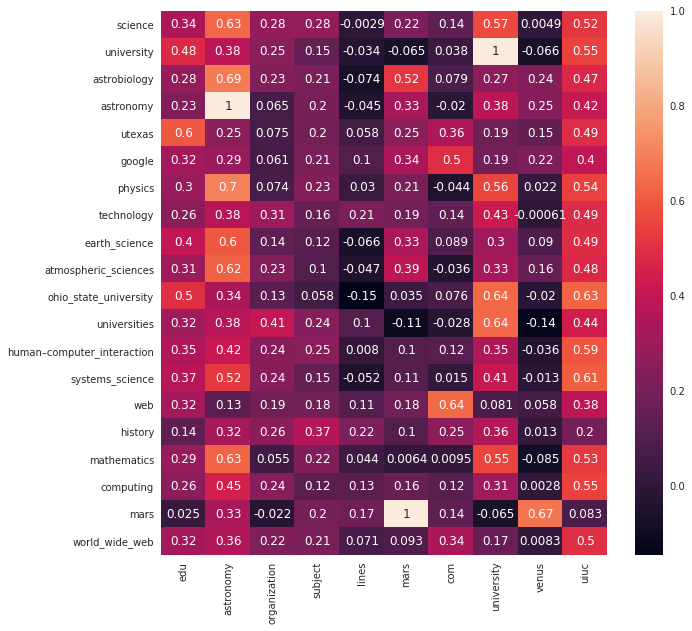

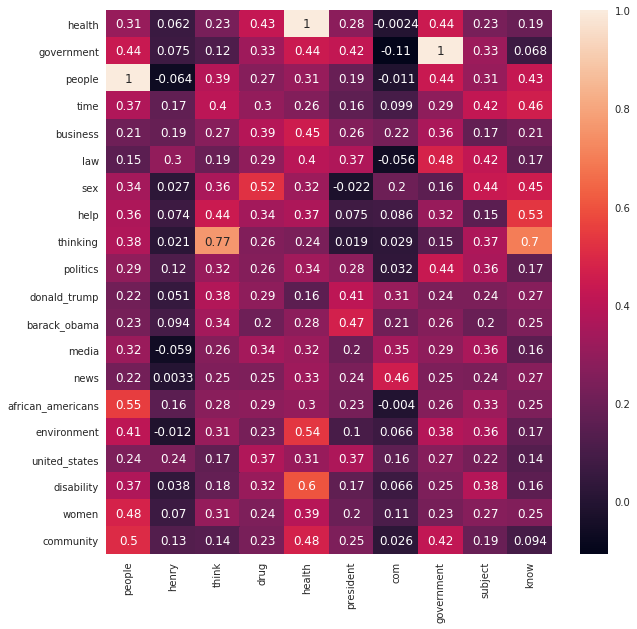

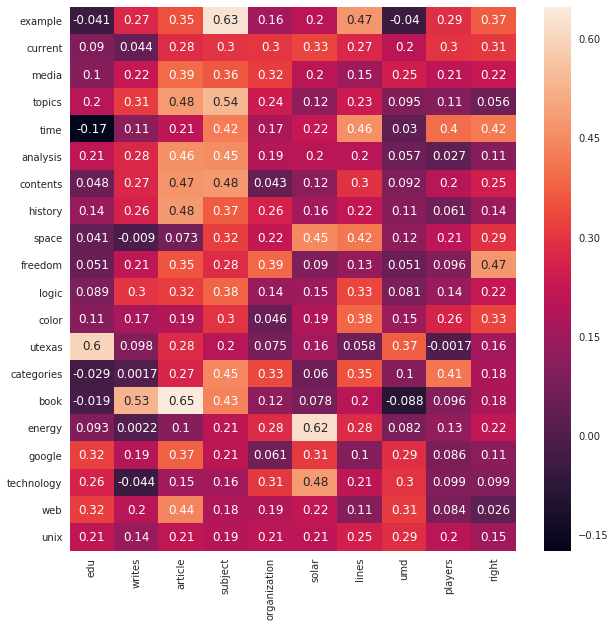

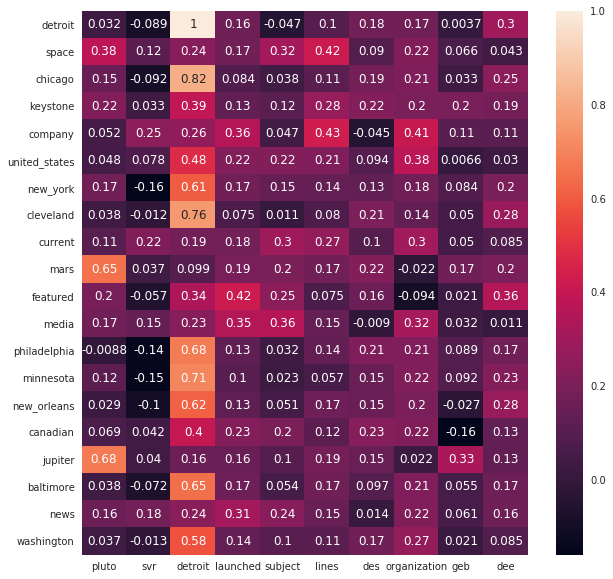

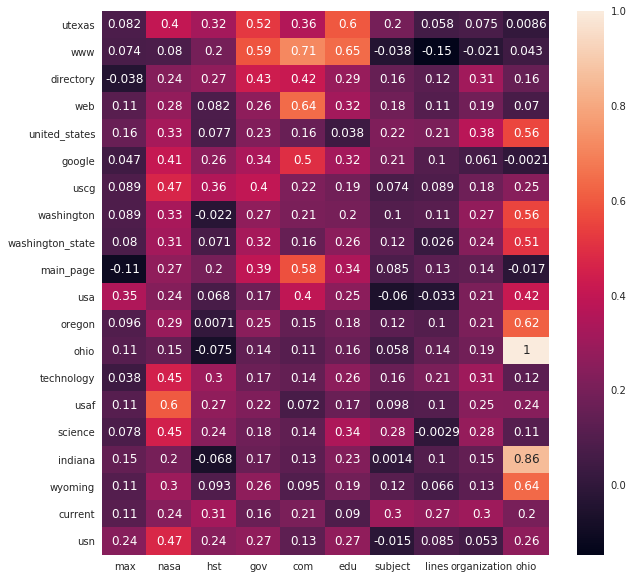

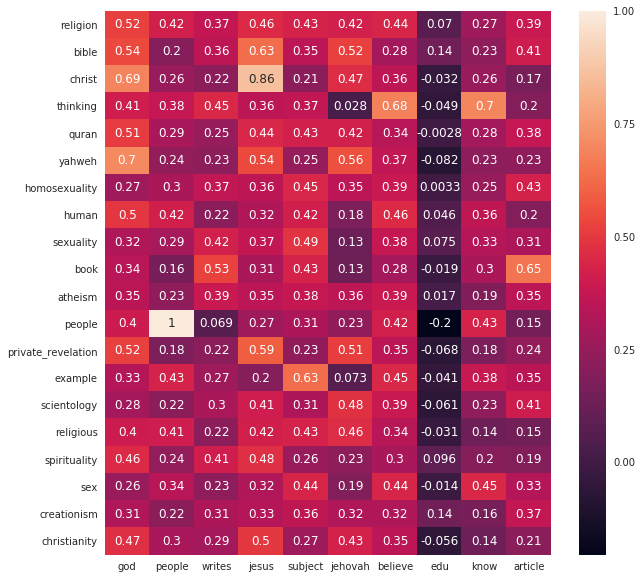

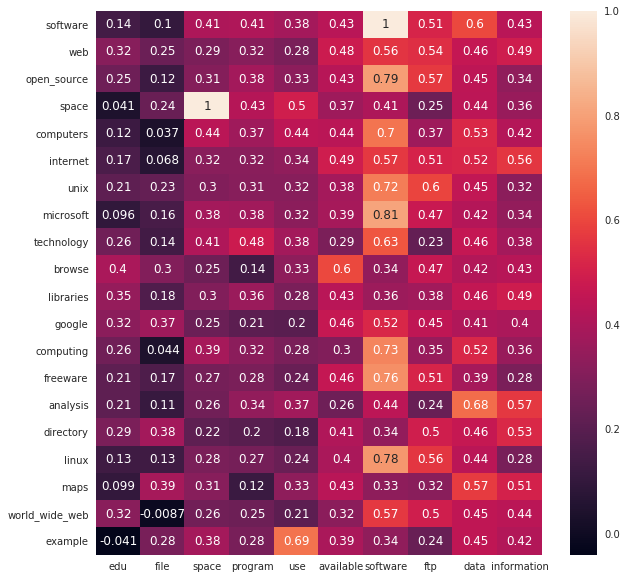

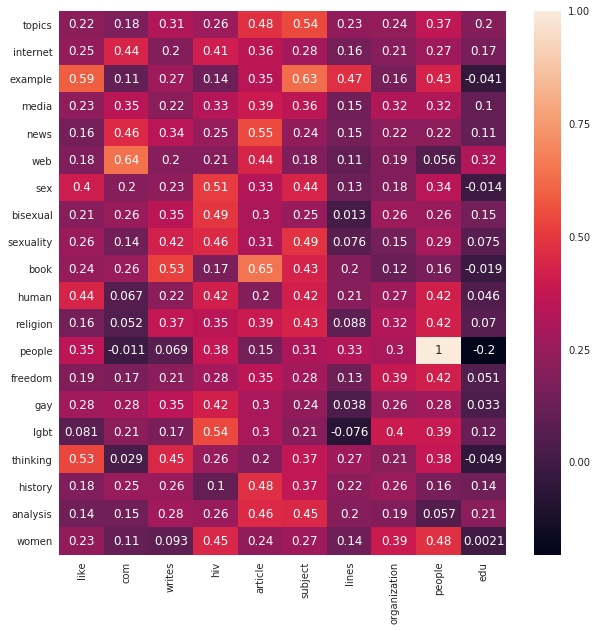

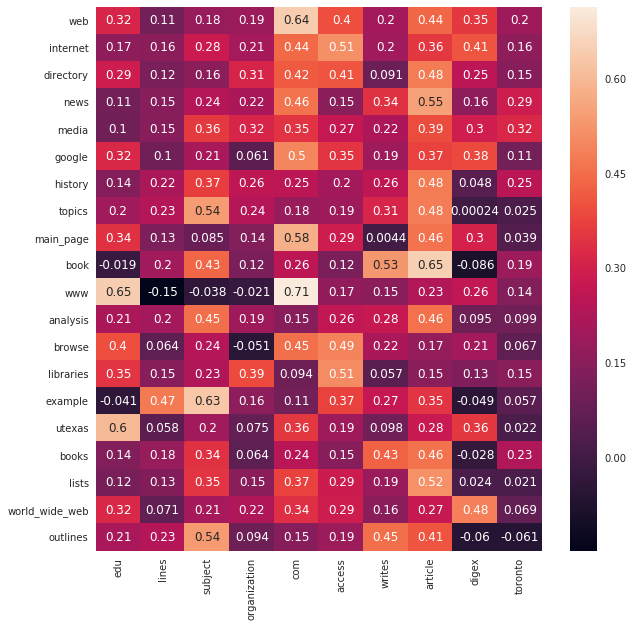

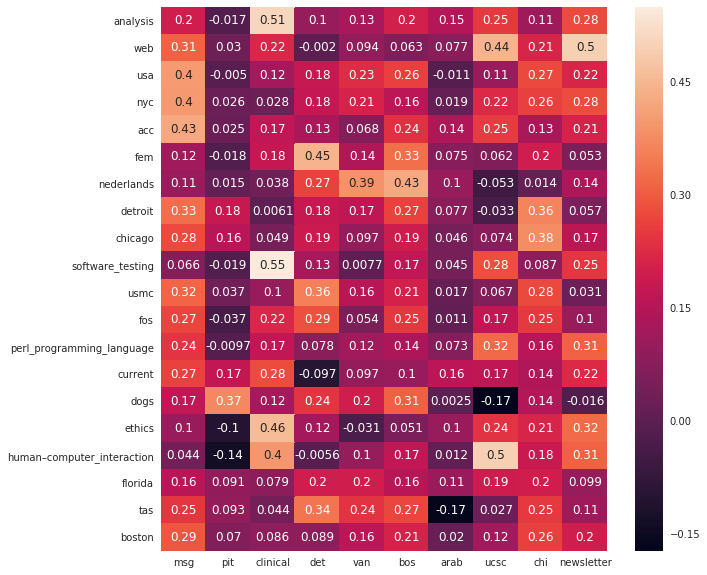

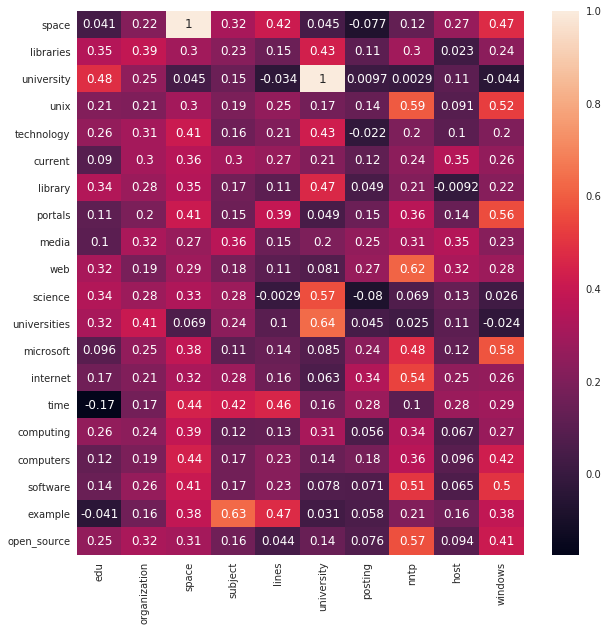

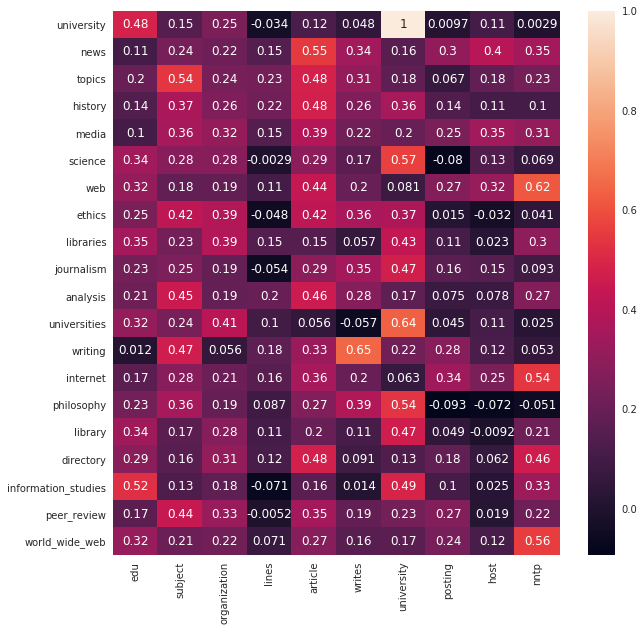

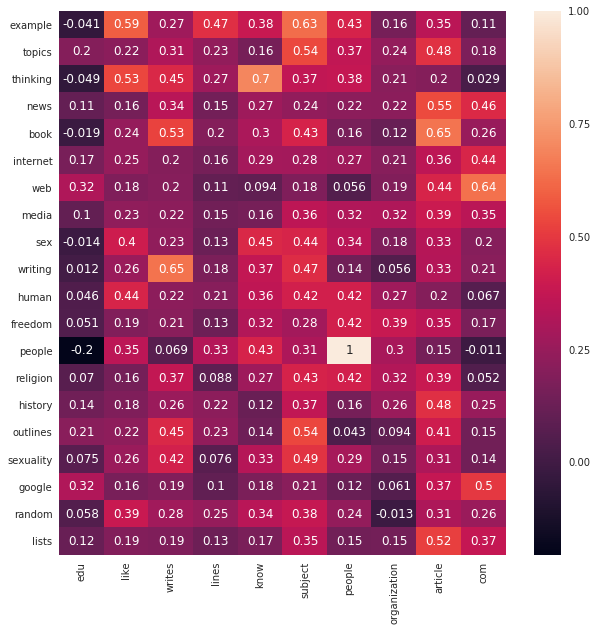

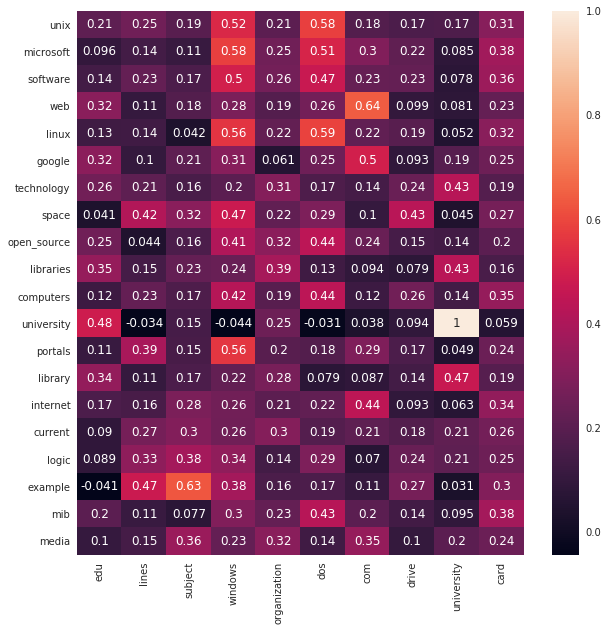

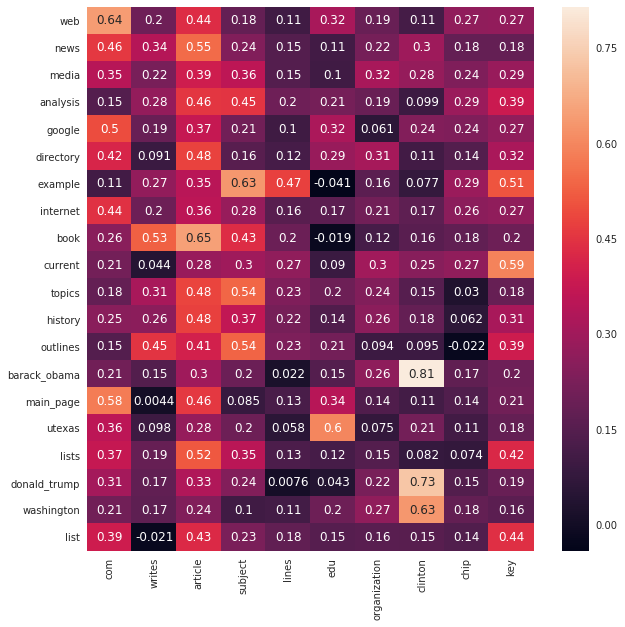

In [148]:
for termlist in NewsgroupsTopicsTerms():
    get_topic_labels(termlist, word_vectors, labels, 20)